In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn import datasets
from scipy.linalg import cholesky, cho_solve
from sklearn.metrics import log_loss

In [2]:
def gaussian(x_p, x_q, theta):
    return np.exp(-0.5 * cdist(x_p/theta, x_q/theta, 'sqeuclidean'))

In [3]:
def s_gaussian(x_p, x_q, theta):
    s = theta[0]
    l = theta[1:]
    return s**2 * gaussian(x_p, x_q, l)

In [4]:
def load_iris_data(normalize_features=True):
    iris = datasets.load_iris()
    x = iris.data[:, :2]
    if normalize_features:
        x -= np.min(x, axis=0)
        x /= np.max(x, axis=0)
    y = iris.target
    return x, y[:, np.newaxis]

In [5]:
x_train, y_train = load_iris_data()
n = x_train.shape[0]
classes = np.unique(y_train)
y_train_one_hot = y_train == classes

In [6]:
def complexity(s, ls, zeta, x_train=x_train, y_train=y_train, n=n, b=y_train_one_hot):
    k = s_gaussian(x_train, x_train, np.append(s, ls))
    k_reg = k + n * zeta * np.eye(n)
    lower = True
    l = cholesky(k_reg, lower=lower)
    v = cho_solve((l, lower), b)
    c = np.trace(np.dot(v.T, np.dot(k, v)))
    return c
    
def decision_probabilities(s, ls, zeta, x_query, x_train=x_train, y_train=y_train, n=n, b=y_train_one_hot):
  
    k = s_gaussian(x_train, x_train, np.append(s, ls))
    k_reg = k + n * zeta * np.eye(n)
    lower = True
    l = cholesky(k_reg, lower=lower)
    k_query = s_gaussian(x_train, x_query, np.append(s, ls))
    p = np.dot(b.T, cho_solve((l, lower), k_query)).T
    return p

def clip_normalize(w):
    w_clip = np.clip(w, 0, np.inf)
    return w_clip / np.sum(w_clip, axis=0)

def classify(p, classes=None):
    if classes is None:
        classes = np.arange(p.shape[1])
    return classes[np.argmax(p, axis=1)]

def cel(s, ls, zeta, x_train=x_train, y_train=y_train, n=n, b=y_train_one_hot):
    p = decision_probabilities(s, ls, zeta, x_train)
    return log_loss(b, p)
#     return np.mean(- np.log((b * p).sum(axis=1)))

def sql(s, ls, zeta, x_train=x_train, y_train=y_train, n=n, b=y_train_one_hot):
    p = decision_probabilities(s, ls, zeta, x_train)
    return np.sum(0.5 * (p - b) ** 2)

def lagrangian(s, ls, zeta):
    return complexity(s, ls, zeta) + cel(s, ls, zeta)

In [7]:
zeta = 1e-4
zeta_array = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

In [8]:
s = np.arange(0, 500, 5) + 5
ls = np.arange(0, 20, 0.5) + 0.5

In [9]:
hypers2d = np.array([[i, j] for i in s for j in ls])
hypers3d = np.array([[i, j, k] for i in s for j in ls for k in zeta_array])

In [10]:
c = np.array([complexity(hypers[0], hypers[1], zeta) for hypers in hypers2d])
xent = np.array([cel(hypers[0], hypers[1], zeta) for hypers in hypers2d])
sqloss = np.array([sql(hypers[0], hypers[1], zeta) for hypers in hypers2d])

In [11]:
i_opt = np.argmin(c)
print(hypers2d[i_opt, 0], hypers2d[i_opt, 1])

500.0 12.0


In [12]:
# c = np.array([complexity(hypers[0], hypers[1], hypers[2]) for hypers in hypers3d])
# xent = np.array([cel(hypers[0], hypers[1], hypers[2]) for hypers in hypers3d])
# sqloss = np.array([sql(hypers[0], hypers[1], hypers[2]) for hypers in hypers3d])

In [13]:
# i_opt = np.argmin(c)
# print(hypers3d[i_opt, 0], hypers3d[i_opt, 1], hypers3d[i_opt, 2])

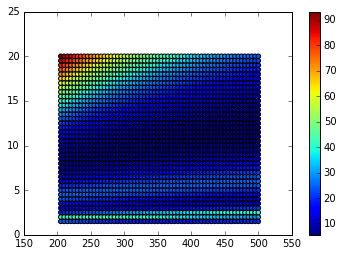

In [14]:
plt.scatter(hypers2d[:, 0], hypers2d[:, 1], c=c)
plt.colorbar()
# plt.scatter(hypers2d[i_opt, 0], hypers2d[i_opt, 1], marker='x', s=40)
plt.show()

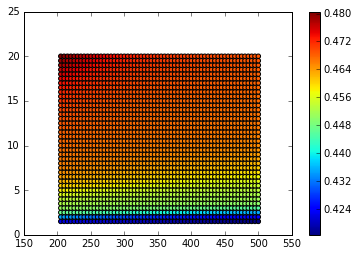

In [15]:
plt.scatter(hypers2d[:, 0], hypers2d[:, 1], c=xent)
# plt.scatter(hypers2d[i_opt, 0], hypers2d[i_opt, 1], marker='x', s=40)
plt.colorbar()
plt.show()

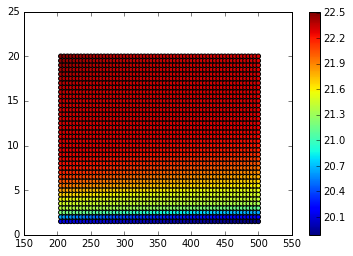

In [16]:
plt.scatter(hypers2d[:, 0], hypers2d[:, 1], c=sqloss)
# plt.scatter(hypers2d[i_opt, 0], hypers2d[i_opt, 1], marker='x', s=40)
plt.colorbar()
plt.show()

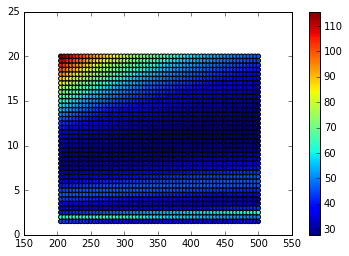

In [17]:
plt.scatter(hypers2d[:, 0], hypers2d[:, 1], c=c + sqloss)
# plt.scatter(hypers2d[i_opt, 0], hypers2d[i_opt, 1], marker='x', s=40)
plt.colorbar()
plt.show()

In [18]:
def visualise(x_train, y_train, s, ls, zeta):

    n_train = x_train.shape[0]
    classes = np.unique(y_train)
    n_classes = classes.shape[0]
    
    x_1_min, x_1_max = x_train[:, 0].min() - .1, x_train[:, 0].max() + .1
    x_2_min, x_2_max = x_train[:, 1].min() - .1, x_train[:, 1].max() + .1
    x_1_lim = (x_1_min, x_1_max)
    x_2_lim = (x_2_min, x_2_max)

    # Generate the query points
    n_query = 250
    x_1_array = np.linspace(*x_1_lim, num=n_query)
    x_2_array = np.linspace(*x_2_lim, num=n_query)
    x_1_mesh, x_2_mesh = np.meshgrid(x_1_array, x_2_array)
    x_query = np.array([x_1_mesh.ravel(), x_2_mesh.ravel()]).T
    
    p = decision_probabilities(s, ls, zeta, x_query)
    p = clip_normalize(p.T).T
    y = classify(p, classes=classes)
    plt.figure()
    Z = np.reshape(p, (n_query, n_query, n_classes))[:, :, ::-1]
    plt.imshow(Z, extent=(x_1_lim[0], x_1_lim[1], x_2_lim[0], x_2_lim[1]), origin="lower")
    Z = np.reshape(y, (n_query, n_query))
    plt.contour(x_1_mesh, x_2_mesh, Z, colors='k', label='Decision Boundaries')
    plt.scatter(x_train[:, 0], x_train[:, 1], c=np.array(["b", "g", "r"])[y_train.ravel()], s=40, label='Training Data')
#     plt.scatter(x_test[:, 0], x_test[:, 1], c=np.array(["b", "g", "r"])[y_test.ravel()], marker='D', s=40, cmap=cm.jet, label='Test Data')
    plt.xlim(x_1_lim)
    plt.ylim(x_2_lim)
    plt.xlabel('$x_{1}$')
    plt.ylabel('$x_{2}$')
    plt.title('Decision Probabilities')
    plt.legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=8, fancybox=True).get_frame().set_alpha(0.5)

In [43]:
def vis(s, ls, zeta):
    visualise(x_train, y_train, s, ls, zeta)
    plt.show()
    print('Complexity:', complexity(s, ls, zeta))
    p = decision_probabilities(s, ls, zeta, x_train)
    y = classify(p)
    print('Cross Entropy: ', log_loss(y_train.ravel(), p))
    print('Accuracy: ', np.mean(y_train.ravel() == y))

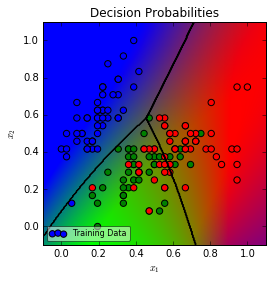

Complexity: 59.3565219696
Cross Entropy:  0.462235710354
Accuracy:  0.8


In [45]:
s = 1.0
ls = 1.0
zeta = 1e-4
vis(s, ls, zeta)

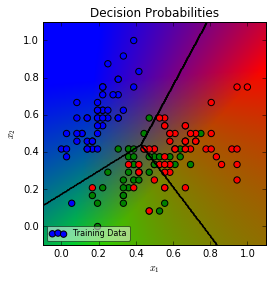

Complexity: 457.66503029
Cross Entropy:  0.612670227129
Accuracy:  0.786666666667


In [46]:
s = 1.0
ls = 10.0
zeta = 1e-4
vis(s, ls, zeta)

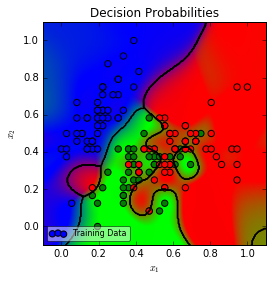

Complexity: 132.28033474
Cross Entropy:  0.255446459831
Accuracy:  0.873333333333


In [47]:
s = 1.0
ls = 0.1
zeta = 1e-4
vis(s, ls, zeta)

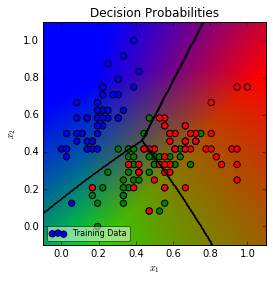

Complexity: 591.16323897
Cross Entropy:  0.591187692784
Accuracy:  0.78


In [48]:
s = 0.1
ls = 1.0
zeta = 1e-4
vis(s, ls, zeta)

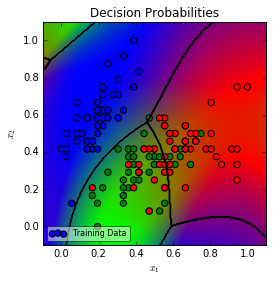

Complexity: 37.3933164746
Cross Entropy:  0.438405742683
Accuracy:  0.813333333333


In [49]:
s = 10.0
ls = 1.0
zeta = 1e-4
vis(s, ls, zeta)

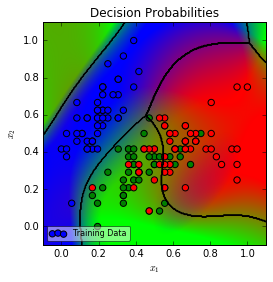

Complexity: 28.5602317295
Cross Entropy:  0.412391081846
Accuracy:  0.826666666667


In [50]:
s = 100.0
ls = 1.0
zeta = 1e-4
vis(s, ls, zeta)

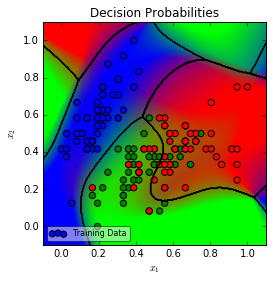

Complexity: 23.6026026768
Cross Entropy:  0.392045900916
Accuracy:  0.84


In [51]:
s = 1000.0
ls = 1.0
zeta = 1e-4
vis(s, ls, zeta)

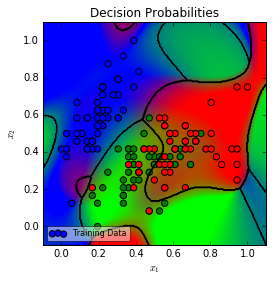

Complexity: 29.1575166819
Cross Entropy:  0.373761379325
Accuracy:  0.84


In [52]:
s = 10000.0
ls = 1.0
zeta = 1e-4
vis(s, ls, zeta)

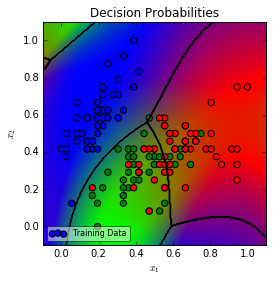

Complexity: 3739.33164782
Cross Entropy:  0.438405742684
Accuracy:  0.813333333333


In [53]:
s = 1.0
ls = 1.0
zeta = 1e-6
vis(s, ls, zeta)

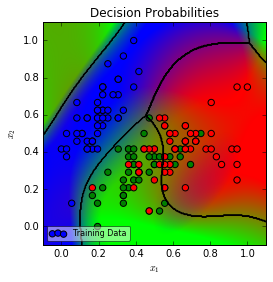

Complexity: 0.285602295383
Cross Entropy:  0.412391082066
Accuracy:  0.826666666667


In [54]:
s = 1000.0
ls = 1.0
zeta = 1e-2
vis(s, ls, zeta)

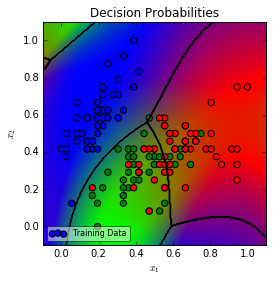

Complexity: 0.00373933164719
Cross Entropy:  0.438405742685
Accuracy:  0.813333333333


In [55]:
s = 1000.0
ls = 1.0
zeta = 1e-0
vis(s, ls, zeta)

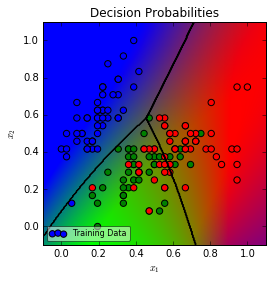

Complexity: 5.93565219696e-05
Cross Entropy:  0.462235710354
Accuracy:  0.8


In [56]:
s = 1000.0
ls = 1.0
zeta = 100.0
vis(s, ls, zeta)

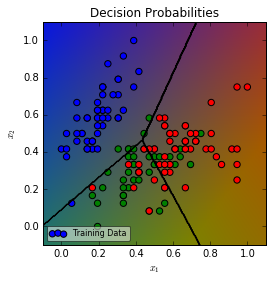

Complexity: 9.56606820682e-07
Cross Entropy:  0.836945190617
Accuracy:  0.793333333333


In [59]:
s = 1000.0
ls = 1.0
zeta = 100000.0
vis(s, ls, zeta)

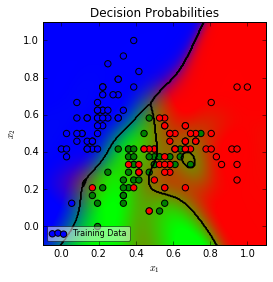

Complexity: 0.0811342623733
Cross Entropy:  0.338509302413
Accuracy:  0.833333333333


In [62]:
s = 10.0
ls = 0.1
zeta = 1.0
vis(s, ls, zeta)

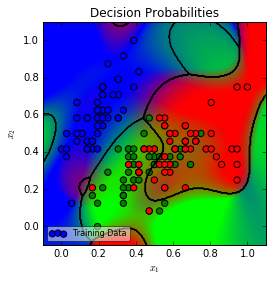

Complexity: 37.1380815582
Cross Entropy:  0.370077806142
Accuracy:  0.826666666667


In [67]:
s = 100.0
ls = 0.5
zeta = 1e-4
vis(s, ls, zeta)